In [19]:
# Tensorflow Keras를 이용해서 Simple Linear Regression을
# 구현해 보아요!
# 독립변수가 1개인 선형회귀모델을 지칭!

# library부터 import작업을 해야 해요!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

In [26]:
# Raw Data Loading

df = pd.read_csv('/content/drive/MyDrive/KOSA 빅데이터 과정 3차/data/ozone/ozone.csv')
display(df)

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


In [27]:
# 온도에 따른 오존량 예측 모델 만들기

# 1. 필요한 컬럼만 가져와서 데이터프레임 다시 만들기
df = df[['Temp', 'Ozone']]
# display(df)


# 2. 데이터 전처리 과정 거치기
df.info() # 난수 있는지부터 확인 #총 152개의 행이 있음(제목까지 153개) 하지만, Ozone에서 맞지 않음

## 난수가 존재하면 안된다 = NaN 값 없애기
df = df.dropna(how='any')
# display(df)
df.info() # 난수를 제거하고 후 #총 116개의 행이 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    153 non-null    int64  
 1   Ozone   116 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    116 non-null    int64  
 1   Ozone   116 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.7 KB


In [28]:
## z-score 을 이용하여 이상치 제거하기
# z-score 로 온도, 오존 이상치 찾기
from scipy import stats
zscore_threshold = 2.0

outlier = df['Ozone'][np.abs(stats.zscore(df['Ozone'])) > zscore_threshold]

df = df.loc[np.isin(df['Ozone'], outlier, invert=True)]
df.info() # 109개로 줄어들었음

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    109 non-null    int64  
 1   Ozone   109 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.6 KB


In [ ]:
## 3. 정규화 처리하기

# 3. 이상치 처리를 다 한후 정규화(Normalization)를 진행
#    정규화는 MinMaxScaling과 Standardization을 일반적으로 이용해요!
#    MinMaxScaling은 최대값과 최소값을 이용해서 scaling
#    만약 이상치가 존재하면 이 방식은 문제가 있어요!
#    그래서 MinMaxScaling을 하려면 반드시 이상치 처리부터 진행해야 해요!

#    그런데 데이터를 다루다보면 이상한 값이긴 한데..(수치적으로)
#    tukey's fences나 zscore를 이용하면 분명히 이상치라고 나오는데..실제로는
#    이상치가 아닌 경우가 존재해요!
#    이런경우에는 이 이상치를 제거하면 안되요..실제로 나올 수 있는 데이터기 때문에..
#    이런경우 평균과 표준편차를 이용한 Standardization방식을 이용해서 정규화
#    하면 되요! 이 방식은 상대적으로 이상치에 관대해요!

# 우리는 MinMaxScaling을 사용할꺼예요!
display(df)

# 계산식을 이용해서 MinMaxScaling을 하려면 구현이 복잡해요!
# 그래서 이 작업역시 library를 이용해서 처리하면 좋아요!
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler는 변환시켜주는 객체예요!
scaler_x = MinMaxScaler()
# scaler에게 최대값과 최소값을 알려줘요!
scaler_x.fit(df['Temp'].values.reshape(-1,1))

x_data = scaler_x.transform(df['Temp'].values.reshape(-1,1))
print(x_data)

In [29]:
# Training Data Set 만들기
x_data = df['Temp'].values.reshape(-1, 1) # 열은 1개고, 열에 맞춰서 행을 결정해주세요(=행위치에 -1 값 넣기)
y_data = df['Ozone'].values.reshape(-1, 1)

In [30]:
# Model 구현

keras_model = Sequential()


# 첫번째 레이어 = input model을 받아들이는 레이어다.
# 동글뱅이가 필요하다 그 개수를 input_shape 안에 넣어주어야 한다. = 독립변수의 개수 넣어주기
keras_model.add(Flatten(input_shape=(1,)))

# 두번째 레이어 = output_model을 반환하는 레이어이다
keras_model.add(Dense(units=1,
                      activation='linear'))

# 모델 학습에 대한 설정
# 어떤 optimizer을 써서 w를 구할지 -> SGD를 사용해서 구하려고 한다
# learning_rate : 어떤 값을 써서 미분 값을 구해주려고 하는지 -> 기준점은 1e-4 넣고 결과를 보면서 적절한 learning_rate를 찾아야한다.
# loss 함수로 'mse' 평균제곱오차를 사용하고 있다
keras_model.compile(optimizer=SGD(learning_rate=1e-4),
                    loss='mse')
# 몇번 반복할지 설정을 해주어야 한다(epochs)
keras_model.fit(x_data, y_data,
                epochs=1000)

# loss 값은 0~1 근삿값이 나와야한다

Epoch 1/1000
4/4 [==============================] - 0s 6ms/step - loss: 4222.8682
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 494.1436
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 530.4601
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 497.6458
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 492.8388
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 501.8485
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 532.4489
Epoch 8/1000
4/4 [==============================] - 0s 4ms/step - loss: 507.0744
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 539.9530
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 521.7960
Epoch 11/1000
4/4 [==============================] - 0s 3ms/step - loss: 523.8610
Epoch 12/1000
4/4 [==============================] - 0s 4ms/step - loss: 538.3928
Epoch 13/1000
4/4 [=====

In [12]:
# 이 모델이 잘 만들어진 모델인지 검증해야함
# 검증 방법이 있는데, 지금은 검증방법을 이용하지 않고 sklearn과 비교해서 우리 모델을 검증한다
# sklearn은 아주 잘 만들어진 모델이라서, 데이터만 넣으면 거의 정답에 가까운 값을 주기 때문에 이것과 비교를 하면 내가 만든 모델이 잘 만들어졌는지 확인할 수 있다.

# 검증이 끝나면 Prediction(예측)을 수행하면 된다
# 2차원으로 변형 후 예측 시작
print(keras_model.predict([62]))

1/1 [==============================] - 0s 112ms/step
[[37.435192]]


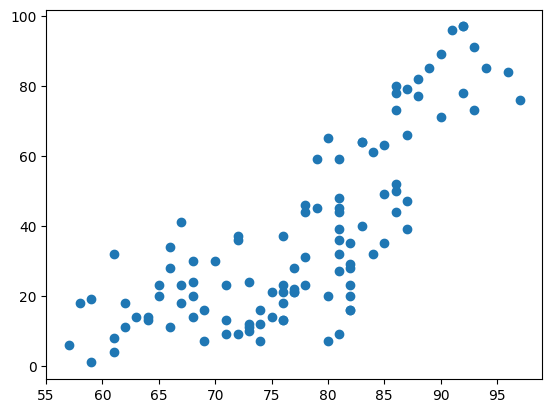

In [31]:
# 그림으로 확인해보고 싶을 때
# 독립변수 1개 이기 때문에 데이터를 scatter를 이용해서 표현할 수 있다
# 우리 모델은 1차 직선 그래프이기 때문에 선 그래프로 표현할 수 있다

plt.scatter(x_data, y_data)
plt.show()

In [32]:
# 직선 그래프를 이용해서 우리가 어떻게 예측했는지 이 데이터를 가장 잘 표현하는 직선 그래프를 그러보자

# 우리 모델의 w와 b값을 알아야 직선의 그래프를 그릴 수 있겠다?
# 해당 레이어를 통해 w와 b값을 찾기 어렵기 때문에 해당 변수를 따로 잡아주어서 넣어준다 위의 코드 밑으로 가져오기
# (y = Wx + b) 우리의 ouput layer를 통해서 W와 b 값을 얻어내기

keras_model = Sequential()

keras_model.add(Flatten(input_shape=(1,)))


output_layer = Dense(units=1,
                      activation='linear')

keras_model.add(output_layer)


keras_model.compile(optimizer=SGD(learning_rate=1e-4),
                    loss='mse')
keras_model.fit(x_data, y_data,
                epochs=1000)

Epoch 1/1000
4/4 [==============================] - 0s 4ms/step - loss: 2542.4341
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 522.9289
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 562.9078
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 532.6446
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 519.8243
Epoch 6/1000
4/4 [==============================] - 0s 3ms/step - loss: 495.1219
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 636.2029
Epoch 8/1000
4/4 [==============================] - 0s 4ms/step - loss: 516.7066
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 536.3419
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 528.1573
Epoch 11/1000
4/4 [==============================] - 0s 4ms/step - loss: 532.7762
Epoch 12/1000
4/4 [==============================] - 0s 5ms/step - loss: 531.2453
Epoch 13/1000
4/4 [=====

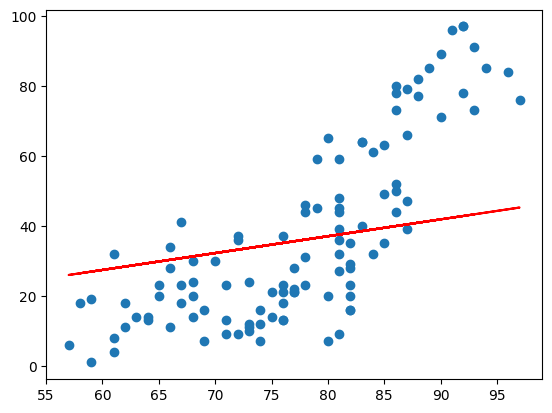

In [33]:
plt.scatter(x_data, y_data)

# W와 b값이 튜플 형태로 나옴
weights, bias = output_layer.get_weights()
plt.plot(x_data, x_data*weights + bias, color ='r')
plt.show()

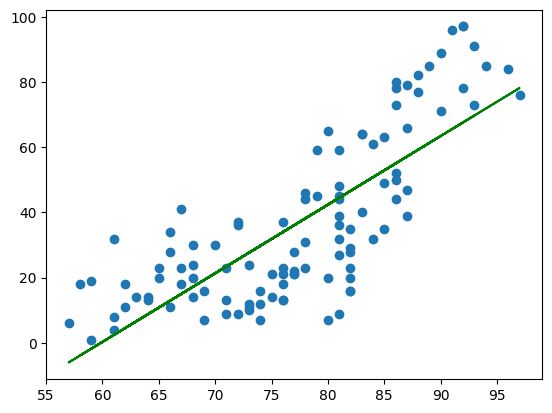

In [34]:
# 위에서 구한 우리의 모델이 잘 만든 모델인지 확인하기 위해
#sklearn으로 모델을 구하고 그래프로 표현
from sklearn import linear_model

# model 생성, 학습
sklearn_model = linear_model.LinearRegression()

# 이렇게 만든 선형회귀 모델에 데이터만 밀어 넣어주면 된다
sklearn_model.fit(x_data, y_data)

# 바로 위 문장을 실행해서 학습을 시켜준 후에
# 결과를 그래프로 그리면 된다

plt.scatter(x_data, y_data)


# W와 b를 이용해서 직선의 그래프(우리 모델)을 그려보자

coef_ = sklearn_model.coef_ # coef_ : sklearn의 학습이 끝나면 나오는 모델의 weights 값
intercept_ = sklearn_model.intercept_ # intercenpt_ : sklearn의 학습이 끝나면 나오는 모델의 bias 값

plt.plot(x_data, x_data*coef_ + intercept_, color='g')
plt.show()

8.0
4.5
11.5
7.0
22.0
-6.0
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False]


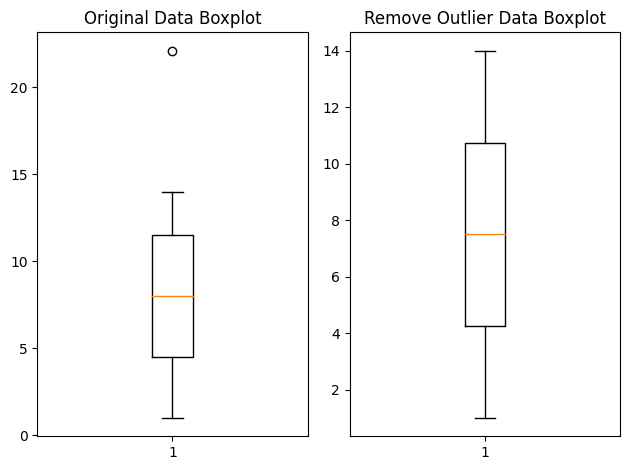

[22.1]


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

In [10]:
# 위 두개의 모델은 왜 차이가 날까?
# 왜 이런 현상이 발생할까?
# 우리 모델이 정답인 sklearn_model 로 돌린 모델과 왜 다른걸까? 뭐가 문제일까?
# 우리가 만든 모델은 이상치를 제외하지 않고 모두 포함에서 모델을 만들었음
# 해결 : 이상치를 제거하는 방법 : 수학 식을 이용해서 제거할 수 있다 -> 즉, 정상적인 데이터가 들어가야 모델이 정상적으로 만들어진다



# 이상치에 대해서 알아보아요!
# 먼저 이상치를 그래프로 살펴보기 위해 Boxplot을 이용

import numpy as np
import matplotlib.pyplot as plt

data = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14, 22.1])


# 그래프를 그리기
## 1, 도화지 준비
fig = plt.figure()
#3 2. subplot을 활용해 도화지 영역 나누기
fig_1 = fig.add_subplot(1,2,1)  # 1행 2열의 첫번째 위치에 subplot을 배치
fig_2 = fig.add_subplot(1,2,2)  # 1행 2열의 두번째 위치에 subplot을 배치

fig_1.set_title('Original Data Boxplot')
fig_1.boxplot(data) # 호출 후에 내가 가지고 있는 데이터 밀어넣기
#plt.show()


# 데이터를 이용해서 사분위 값을 알아내기
print(np.median(data)) # 2사문위, 중위값
print(np.percentile(data,25)) # 25%의 값, 제 1사문위 값
print(np.percentile(data,75)) # 75%의 값, 제 3사분위 값

iqr_value = np.percentile(data, 75) - np.percentile(data, 25)
print(iqr_value)

upper_fence = np.percentile(data, 75) + (iqr_value * 1.5)
print(upper_fence)
lower_fence = np.percentile(data, 25) - (iqr_value * 1.5)
print(lower_fence)

## 그럼 내가 가진 데이터에서 이상치를 찾아서 제거하고,
## 남은 정상적인 데이터를 추출
print((data <= upper_fence) & (data >= lower_fence))

result_data = data[(data <= upper_fence) & (data >= lower_fence)]

fig_2.set_title('Remove Outlier Data Boxplot')
fig_2.boxplot(result_data)

fig.tight_layout()

plt.show()

In [16]:
## z-score 이용하여 이상치 처리하기
from scipy import stats

data = np.array([3,30,35,40,45,48,49,50,51,52,53,55,60,65,90,95])


# z-score은 2.0 이 가장 많이 사용됨
zscore_threshold = 2.0

outlier = data[np.abs(stats.zscore(data)) > zscore_threshold]
print(outlier)

# 이상치를 제거한 결과는
data[np.isin(data, outlier, invert=True)]


[ 3 95]


array([30, 35, 40, 45, 48, 49, 50, 51, 52, 53, 55, 60, 65, 90])